<a href="https://colab.research.google.com/github/LokeshSaipureddi/Diabetic_retinopathy/blob/LokeshSaipureddi-patch-1/FPN_messidor2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install -q kaggle

In [ ]:
import tensorflow as tf

In [ ]:
!pip install pydot

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'xyaustin/messidor2'

 99% 2.27G/2.29G [00:20<00:00, 110MB/s] 
100% 2.29G/2.29G [00:20<00:00, 118MB/s]


In [ ]:
!mkdir messidor2

In [ ]:
! unzip messidor2.zip -d messidor2

Archive:  messidor2.zip
  inflating: messidor2/messidor-2/images/20051020_43808_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_43832_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_43882_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_43906_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44261_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44284_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44338_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44349_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44400_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44431_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44598_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44636_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44692_0100_PP.png  
  inflating: messidor2/messidor-2/images/20051020_44714_0100_PP.pn

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout,Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.metrics import AUC,Precision,Recall
from sklearn.model_selection import KFold
import math
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import random
import shutil
import glob

In [ ]:
import os
os.mkdir("/content/messidor2/messidor-2/0")
os.mkdir("/content/messidor2/messidor-2/1")
os.mkdir("/content/messidor2/messidor-2/2")
os.mkdir("/content/messidor2/messidor-2/3")
os.mkdir("/content/messidor2/messidor-2/4")

In [ ]:
import os
os.remove("/content/messidor2/messidor-2/images/20060411_58550_0200_PP.png")
os.remove("/content/messidor2/messidor-2/images/IM002385.jpg")
os.remove("/content/messidor2/messidor-2/images/IM003718.jpg")
os.remove("/content/messidor2/messidor-2/images/IM004176.jpg")
# importing pandas module


In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
path='/content/messidor2/messidor-2/images'
img_list=os.listdir(path)
len(img_list)

1744

In [ ]:
#applying clahe
c=0
for i in img_list:
  img_path=path+'/'+str(i)
  img=cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  dst1 = cv2.fastNlMeansDenoising(img,None,3,7,21)
  clahe = cv2.createCLAHE(clipLimit = 5)
  img = clahe.apply(dst1)+30
  cv2.imwrite(str(i),img)
  c=c+1
  print(c) 
#removing files in images folder
fileinimages=os.listdir(path)
for i in fileinimages:
  os.remove(path+'/'+str(i))
filelist=os.listdir('/content/')
filelistjpg=[]
for fichier in filelist:
    if (fichier.endswith(".JPG")) or fichier.endswith('.png') or fichier.endswith('.jpeg') or fichier.endswith('.jpg'):
        filelistjpg.append(fichier)
print(filelistjpg)
print(len(filelistjpg))
for i in filelistjpg:
  source='/content/'+str(i)
  dest='/content/messidor2/messidor-2/images'
  shutil.move(source,dest)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv("/content/messidor2/messidor-2/messidor_data.csv")

# making new data frame with dropped NA values
data.dropna(subset=["adjudicated_dr_grade"],inplace=True)
data.to_csv('messidor_data2.csv')
# comparing sizes of data frames
print("Old data frame length:", len(data))

os.remove("/content/messidor2/messidor-2/messidor_data.csv")
import shutil
shutil.move("/content/messidor_data2.csv","/content/messidor2/messidor-2")


Old data frame length: 1744


'/content/messidor2/messidor-2/messidor_data2.csv'

In [ ]:
import shutil, os
import pandas as pd

labels = pd.read_csv("/content/messidor2/messidor-2/messidor_data2.csv")
labels = labels.sort_values('adjudicated_dr_grade')

In [ ]:
class_names = list(labels.adjudicated_dr_grade.unique())
print(class_names)

[0.0, 1.0, 2.0, 3.0, 4.0]


In [ ]:
class_names = list(labels.adjudicated_dr_grade.unique())
A = [int(class_names) for class_names in class_names]
print(A)

[0, 1, 2, 3, 4]


In [ ]:
for c in A: # Category Name
  for i in list(labels[labels['adjudicated_dr_grade']==c]['image_id']): # Image Id
    get_image = os.path.join('/content/messidor2/messidor-2/images/', i) # Path to Images
    move_image_to_cat = shutil.copy(get_image, '/content/messidor2/messidor-2/'+str(c))

In [ ]:
ls1=os.listdir('/content/messidor2/messidor-2/1')
ls2=os.listdir('/content/messidor2/messidor-2/2')
ls3=os.listdir('/content/messidor2/messidor-2/3')
ls4=os.listdir('/content/messidor2/messidor-2/4')
os.mkdir('/content/messidor2/messidor-2/comb1234')

In [ ]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls1:
  img_scr=path+'/1/'+str(i)
  shutil.move(img_scr,dest)

In [ ]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls2:
  img_scr=path+'/2/'+str(i)
  shutil.move(img_scr,dest)

In [ ]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls3:
  img_scr=path+'/3/'+str(i)
  shutil.move(img_scr,dest)

In [ ]:
path='/content/messidor2/messidor-2'
dest='/content/messidor2/messidor-2/comb1234'
for i in ls4:
  img_scr=path+'/4/'+str(i)
  shutil.move(img_scr,dest)

In [ ]:
for i in range(1,5):
  shutil.rmtree('/content/messidor2/messidor-2/'+str(i))

In [ ]:
os.rename('/content/messidor2/messidor-2/comb1234','/content/messidor2/messidor-2/1')

In [ ]:
original_data_path = "/content/messidor2/messidor-2"
train_pct = 0.8
test_pct = 0.1
val_pct = 0.1

if os.path.isdir("/content/messidor2/messidor-2/train/0") is False:
    # create folders for the sets
    os.mkdir("/content/messidor2/messidor-2/train")
    os.mkdir("/content/messidor2/messidor-2/test")
    os.mkdir("/content/messidor2/messidor-2/validation")
    for i in range(0, 2):
        # path to inputs with different classes
        num_folder_path = f'{original_data_path}/{i}' 
        num_files_in_folder = len(os.listdir(num_folder_path))
        train_size1 = int(num_files_in_folder * train_pct)
        test_size1 = int(num_files_in_folder * test_pct)
        val_size = int(num_files_in_folder * val_pct)
        train_size = train_size1
        test_size = test_size1
        os.mkdir(f'/content/messidor2/messidor-2/train/{i}')
        os.mkdir(f'/content/messidor2/messidor-2/test/{i}')
        os.mkdir(f'/content/messidor2/messidor-2/validation/{i}')
        test_samples = random.sample(os.listdir(num_folder_path), test_size)
        for file_name in test_samples:
            shutil.move((f"/content/messidor2/messidor-2/{i}/{file_name}"), f'/content/messidor2/messidor-2/test/{i}')
        val_samples = random.sample(os.listdir(num_folder_path), val_size)
        for file_name in val_samples:
            shutil.move((f"/content/messidor2/messidor-2/{i}/{file_name}"), f'/content/messidor2/messidor-2/validation/{i}')    
        train_samples = random.sample(os.listdir(num_folder_path), train_size)
        for file_name in train_samples:
            shutil.move((f"/content/messidor2/messidor-2/{i}/{file_name}"), f'/content/messidor2/messidor-2/train/{i}')

In [ ]:
train_path="/content/messidor2/messidor-2/train"
test_path="/content/messidor2/messidor-2/test"
val_path='/content/messidor2/messidor-2/validation'

In [ ]:
shape=(512,512,1)

In [ ]:
# CLASS_MODE = "categorical"
# BATCH_SIZE = 16
# train_batches = ImageDataGenerator(rescale=1./223,
#                                    featurewise_center=True,
#     brightness_range=[-0.3,0.3],
    
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True).flow_from_directory(directory = train_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE,shuffle=True)
# val_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = val_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
# test_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = test_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)

In [ ]:
CLASS_MODE = "categorical"
BATCH_SIZE = 16
train_batches = ImageDataGenerator(rescale=1./223,
                                   featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True).flow_from_directory(directory = train_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE,shuffle=True)
val_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = val_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
test_batches = ImageDataGenerator(rescale=1./223).flow_from_directory(directory = test_path, target_size = shape[:2], batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)

Found 1394 images belonging to 2 classes.
Found 173 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


<Figure size 432x288 with 0 Axes>

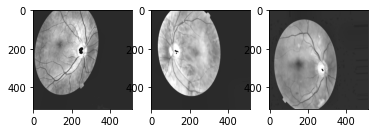

In [ ]:
plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,5)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0])) 

In [ ]:
IMG_SIZE = (224,224)
batch_size = 64
epoch = 200

In [ ]:
!pip install keras_retinanet

     |████████████████████████████████| 71 kB 4.0 MB/s 
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=163913 sha256=b1570c11f4bf2b51dfe19615e1b3d0a88b6cfe24df274ea6713d908a0bca2317
  Stored in directory: /root/.cache/pip/wheels/55/a1/41/f2dbc08b26549fe00041b9bc25c299f262b0311ad68cc52522
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=a0daec85f747b5ffffece4bb593a73ed1c394118eba58cd4ab5bc5877463d962
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-retinanet keras-resnet


In [ ]:
import tensorflow 
from tensorflow import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout, Flatten, Dense,Input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
from keras_retinanet import layers
import tensorflow.keras.backend as k
import keras_retinanet

In [ ]:
fold_num=1

In [ ]:
from tensorflow.keras.metrics import AUC, Precision, Recall, FalseNegatives, FalsePositives,TrueNegatives,TruePositives, CategoricalCrossentropy

In [ ]:
k.clear_session() #Clear tensorflow.keras backend 
try:
  os.mkdir('models1') #create folder for saving the trained networks
except:
  pass
full_name='ResNet50V2-FPN-fold{}'.format(fold_num)
classes_number=2 #Number of classes (normal and COVID-19)
input_tensor=Input(shape=(512,512,3))
weight_model = ResNet50V2(weights='imagenet', include_top=False) #Load ResNet50V2 ImageNet pre-trained weights
weight_model.save_weights('weights.h5') #Save the weights
base_model = ResNet50V2(weights=None, include_top=False, input_tensor=input_tensor) #Load the ResNet50V2 model without weights
base_model.load_weights('weights.h5',skip_mismatch=True, by_name=True) #Load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)
 
#Create Feature Pyramid Network (FPN)
# We used some help for writing the Pyramid from the written code on https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/models/retinanet.py
feature_size=512 #Set the feature channels of the FPN
layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"] #Layers of ResNet50V2 with different scale features 
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5=layer_outputs #Features of different scales, extracted from ResNet50V2
P5           = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
P5           = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)
 
# Concatenate P5 elementwise to C4
P4           = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
P4           = tensorflow.keras.layers.Concatenate(axis=3)([P5_upsampled, P4])
P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
P4           = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)
 
# Concatenate P4 elementwise to C3
P3 = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
P3 = tensorflow.keras.layers.Concatenate(axis=3)([P4_upsampled, P3])
P3 = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3)
 
# "P6 is obtained via a 3x3 stride-2 conv on C5"
P6 = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)
 
# "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
P7 = tensorflow.keras.layers.Activation('relu', name='C6_relu')(P6)
P7 = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)
 
# Run classification for each of the generated features from the pyramid
feature1 = Flatten()(P3)
dp1 = Dropout(0.5)(feature1)
preds1 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp1)
feature2 = Flatten()(P4)
dp2 = Dropout(0.5)(feature2)
preds2 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp2)
#################################################################
feature3 = Flatten()(P5)
dp3= Dropout(0.5)(feature3)
preds3 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp3)
#################################################################
feature4 = Flatten()(P6)
dp4 = Dropout(0.5)(feature4)
preds4 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp4)
#################################################################
feature5 = Flatten()(P7)
dp5 = Dropout(0.5)(feature5)
preds5 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp5)
#################################################################
concat=tensorflow.keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5]) #Concatenate the predictions(Classification results) of each of the pyramid features 
out=tensorflow.keras.layers.Dense(2,activation='softmax',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(concat) #Final Classification
 
model = Model(inputs=base_model.input, outputs=out) #Create the Training Model
#######################################################
for layer in model.layers:
  layer.trainable = True
model.compile(optimizer=optimizers.Nadam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy',AUC(),Precision(),Recall(),FalsePositives(),TrueNegatives(),TruePositives(),FalseNegatives()])
filepath="models/%s-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name  # Path to save the trained models
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]
 
#model.fit(train_batches, epochs=20,validation_data=val_batches,shuffle=True,callbacks=callbacks_list) #start training
hist = model.fit(train_batches, validation_data=test_batches , epochs=30,callbacks=callbacks_list)

94674944/94668760 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
88/88 [==============================] - 158s 1s/step - loss: 0.6824 - accuracy: 0.5854 - auc: 0.5983 - precision: 0.5854 - recall: 0.5854 - false_positives: 578.0000 - true_negatives: 816.0000 - true_positives: 816.0000 - false_negatives: 578.0000 - val_loss: 0.6752 - val_accuracy: 0.5838 - val_auc: 0.6632 - val_precision: 0.5838 - val_recall: 0.5838 - val_false_positives: 72.0000 - val_true_negatives: 101.0000 - val_true_positives: 101.0000 - val_false_negatives: 72.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
88/88 [==============================] - 117s 1s/step - loss: 0.6215 - accuracy: 0.6055 - auc: 0.7015 - precision: 0.6055 - recall: 0.6055 - false_positives: 550.0000 - true_negatives: 844.0000 - true_positives: 844.0000 - false_negatives: 550.0000 - val_loss: 0.7932 - val_accuracy: 0.5838 - val_auc: 0.7041 - val_precision: 0.5838 - val_recall: 0.5838 - val_false_positives: 72.0000 - val_true_negatives: 101.0000 - val_true_positives: 101.0000 - val_false_negatives: 72.0000
Epoch 3/30
88/88 [==============================] - 117s 1s/step - loss: 0.5575 - accuracy: 0.7317 - auc: 0.7948 - precision: 0.7317 - recall: 0.7317 - false_positives: 374.0000 - true_negatives: 1020.0000 - true_positives: 1020.0000 - false_negatives: 374.0000 - val_loss: 0.9081 - val_accuracy: 0.6474 - val_auc: 0.7327 - val_precision: 0.6474 - val_recall: 0.6474 - val_false_positives: 61.0000 - val_true_negatives: 112.0000 - val_true_positives: 112.0000 - val_false_negatives: 61.0000
Epoch 4/30
88/88 [==

In [ ]:
model.summary()

In [ ]:
layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"] #Layers of ResNet50V2 with different scale features 
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5=layer_outputs #Features of different scales, extracted from ResNet50V2
P5           = tensorflow.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = UpsampleLike([P5, C4])

In [ ]:
P5

In [ ]:
x = Flatten()(model.layers[-100].output)
x=Dense(units=1024)(x)
output = Dense(units=2, activation="sigmoid")(x)
model = Model(inputs = model.input, outputs = output)

In [ ]:
initial_lrate = 0.0000001
def decay(epoch, steps=10):
    initial_lrate = 0.000008
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
opt = RMSprop(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)
model.compile(optimizer=opt,
              loss=tf.tensorflow.keras.losses.binary_crossentropy,
              metrics=['accuracy',AUC(),Precision(),Recall(),FalsePositives(),TrueNegatives(),TruePositives(),FalseNegatives()])

In [ ]:
checkpoint = ModelCheckpoint("weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, mode='auto',patience=25)
callback = [checkpoint,early]
hist = model.fit(train_batches, validation_data=test_batches , epochs=epoch,callbacks=callback)

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
target_names = []

for key in train_batches.class_indices:

    target_names.append(key)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


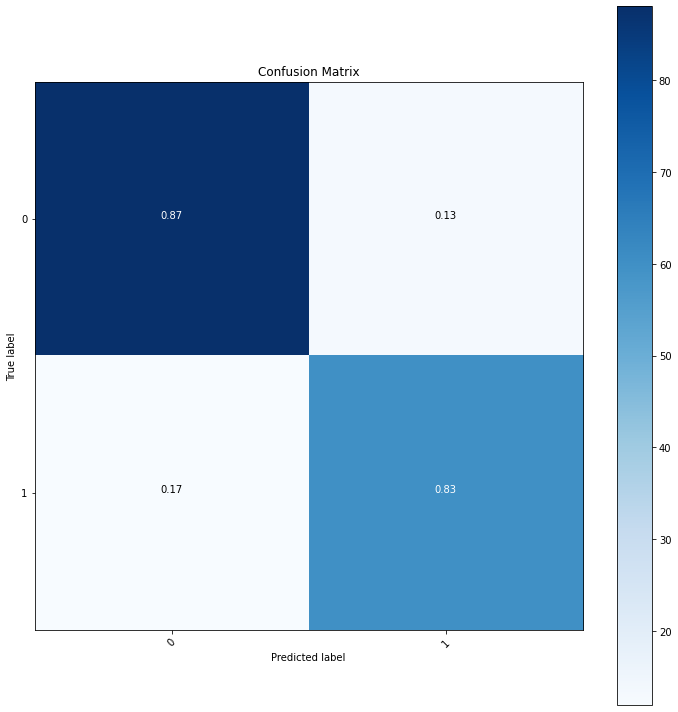

In [ ]:
Y_pred = model.predict_generator(test_batches)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_batches.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
model.load_weights('/content/models/ResNet50V2-FPN-fold1-17-0.8555.hdf5')

In [ ]:
model_metrics = model.evaluate(test_batches,verbose=0)

In [ ]:
f1_score = 2*( (model_metrics[3]*model_metrics[4]) / (model_metrics[3]+model_metrics[4]) )

In [ ]:
print(f"Accuracy on test set: {round(model_metrics[1]*100,2)}%")
print(f"ROC(Receiver Operation Characteristic) AUC(Area Under Curve): {model_metrics[2]}")
print(f"Precision: {round(model_metrics[3]*100,2)}%")
print(f"Recall: {round(model_metrics[4]*100,2)}%")
print(f"F1-score: {f1_score}")
print(f"Specificity: {(model_metrics[6])/(model_metrics[6]+model_metrics[5])}")

Accuracy on test set: 85.55%
ROC(Receiver Operation Characteristic) AUC(Area Under Curve): 0.9226167798042297
Precision: 85.55%
Recall: 85.55%
F1-score: 0.8554913401603699
Specificity: 0.8554913294797688


In [ ]:
lr_probs = model.predict(test_batches)

In [ ]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(test_batches.classes, y_pred)

In [ ]:
fpr1

array([0.        , 0.12871287, 1.        ])

In [ ]:
thresh1

array([2, 1, 0])

In [ ]:
fpr1, tpr1, thresh1 = roc_curve(test_batches.classes, y_pred)

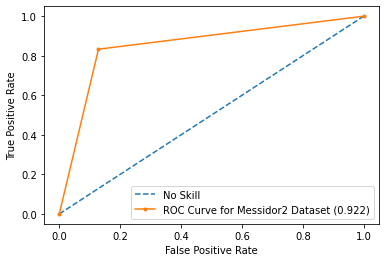

In [ ]:
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
pyplot.plot(fpr1, tpr1, marker='.', label='ROC Curve for Messidor2 Dataset (0.922)')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()